# flyswot-gym 🦾

This notebook moves through the steps involved in training/updating a flyswot model. 

> This notebook assumes you have already updated the flysheet `dataset` (see the [flyswot-gym](https://github.com/davanstrien/flyswot-gym) repository for guidance on doing this.). 

The notebook goes through the following steps:
- downloading the training data
- preparing the dataset for training the model
- training the model 
- evaluating the model in various ways
- making a decision about whether to save the model 
- uploading the model to the 🤗 hub

**Note: this notebook is a WIP, things might change or not work properly**

In [ ]:
#@title Setup git and git-lfs
!apt install git-lfs && git init && git lfs install 
!git config --global credential.helper store

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.



In [ ]:
#@title Install flyswot-gym
!pip -q install git+https://github.com/davanstrien/flyswot-gym.git

In [ ]:
from huggingface_hub import notebook_login
from huggingface_hub import hf_api
import torch

### Check for we have a GPU available

Google Colab gives us the option of running our code on a GPU. This is important for speeding up our training process. If the below cell fails check you have a GPU enabled. Sometimes you may have to wait a little while for Colab to have GPUs available. 


In [ ]:
assert torch.cuda.is_available()

AssertionError: 

## Define some training options

We define some different training options. The first `model_checkpoint` refers to the model we *start* our training from. This is setup to use an existing flyswot model by default. If you have made massive changes to the data, or are training on a new task you may want to change this model to another model. Any `image-classification` [model](https://huggingface.co/models?pipeline_tag=image-classification) *should* work. A safe bet is to start with `facebook/convnext-tiny-224`. To use any of these models pass in the Hub id. You can get this from the top of a model page on the hub by clicking on the double square icon

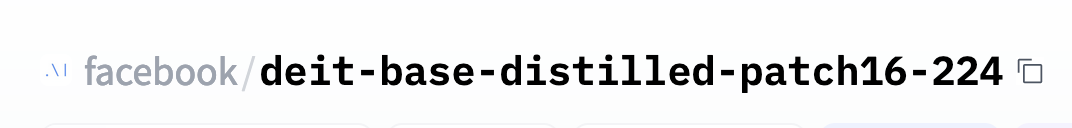

The other options are `training_dataset` this should point to a dataset you've uploaded using `hugit`. 

The number of epochs defines how long you will train your model for. If you are fine tuning an existing flyswot model you won't need to change this much but if you are training something new you will want to increase this value. 

In [ ]:
#@title Define training options
model_checkpoint = 'flyswot/convnext-tiny-224_flyswot' #@param ["flyswot/convnext-tiny-224_flyswot", "davanstrien/deit_flyswot"] {allow-input: true}
training_dataset = "davanstrien/hugit_hmd_flysheet" #@param ["flyswot/flysheet_data"] {allow-input: true}
number_of_epochs = 10 #@param {type:"slider", min:10, max:100, step:1}

## Tips

This notebook attempts to make the process of training/updating a model easier. This is partially done by creating some functions that do a bunch of different steps for you. In this notebook we often just call these functions. This means we see a couple of lines of code instead of a whole bunch of code. However, nothing is supposed to be hidden or magical because of this. If you want to know what a particular function is doing you can use a handy feature inside notebook to see what some code does. 
Placing `??` will show the source code for a function, for example, we can take a look at what `prep_data` is doing:

In [ ]:
from flyswot_gym.core import prep_data

In [ ]:
??prep_data

Signature: prep_data(ds_checkpoint='davanstrien/flysheet', model_checkpoint=None)
Docstring: <no docstring>
Source:   
def prep_data(ds_checkpoint="davanstrien/flysheet", model_checkpoint=None):
    try:
        ds = load_dataset(ds_checkpoint, use_auth_token=True, streaming=False, split='train')
        labels = ds.info.features['label'].names
        id2label = dict(enumerate(labels))
        label2id = {v:k for k,v in id2label.items()}
        train, valid, test = prepare_dataset(ds)
        train_ds, valid_ds, test_ds = prepare_transforms(model_checkpoint, train, valid, test)
        return FlyswotData(train_ds, valid_ds, test_ds, id2label, label2id)
    except FileNotFoundError as e:
        print(f"{e} make sure you are logged into the Hugging Face Hub")
File:      ~/miniconda3/envs/flyswot-gym/lib/python3.8/site-packages/flyswot_gym/core.py
Type:      function


This means firstly that you can see more clearly what is happening but also if you feel like it's doing the wrong thing you can copy the code an update how that step of the notebook happens. 

# Login to the 🤗 hub 

Since we're using private datasets and we want to have the option of pushing our models to the 🤗 hub we ned to ensure we are logged in.

In [ ]:
notebook_login()

In [ ]:
api = hf_api.HfApi()
assert api._validate_or_retrieve_token()[0], "not logged in! Please try cell above again"

## Setup training data

This part of the notebook setups the training data for our model. The way in which the data is processed changes depending on our model which is why we need to pass in `model_checkpoint`. 

In [ ]:
from flyswot_gym.core import prep_data

In [ ]:
flyswot_data = prep_data(training_dataset, model_checkpoint=model_checkpoint)

Using custom data configuration davanstrien--hugit_hmd_flysheet-6becb318f00fc0f9
Reusing dataset parquet (/Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--hugit_hmd_flysheet-6becb318f00fc0f9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901)


Preparing dataset...

dropping duplicates...

Loading cached processed dataset at /Users/dvanstrien/.cache/huggingface/datasets/parquet/davanstrien--hugit_hmd_flysheet-6becb318f00fc0f9/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901/cache-5de6b5225446f1b1.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

getting ID...

  0%|          | 0/1275 [00:00<?, ?ex/s]

creating train, valid, test splits...

train has 892 examples

valid has 268 examples

test has 115 examples

In [ ]:
assert flyswot_data, "make sure you have loaded data sucessfully"

## Model training 
We now have our data ready, next we train a model. By default this will use the paramters we chose earlier but we can switch this around if needed. The `hub_model_id` variable defines what name our model will be saved as on the Hugging Face hub. This defaults to "flyswot". 

In [ ]:
from flyswot_gym import core

In [ ]:
trainer = core.train_model(flyswot_data,
                           model_checkpoint, 
                           num_epochs=num_epochs)

Dataset({
    features: ['image', 'label', 'fpath', 'clean_path', 'id'],
    num_rows: 892
})

Cloning https://huggingface.co/flyswot/flyswot into local empty directory.


Download file pytorch_model.bin:   0%|          | 1.58k/106M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.11k/3.11k [00:00<?, ?B/s]

Clean file training_args.bin:  32%|###2      | 1.00k/3.11k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/106M [00:00<?, ?B/s]

[codecarbon INFO @ 18:30:12] [setup] RAM Tracking...
[codecarbon INFO @ 18:30:12] [setup] GPU Tracking...
[codecarbon INFO @ 18:30:12] No GPU found.
[codecarbon INFO @ 18:30:12] [setup] CPU Tracking...
[codecarbon WARNING @ 18:30:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 18:30:14] We saw that you have a Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 18:30:14] CPU Model on constant consumption mode: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
[codecarbon INFO @ 18:30:14] >>> Tracker's metadata:
[codecarbon INFO @ 18:30:14]   Platform system: macOS-10.16-x86_64-i386-64bit
[codecarbon INFO @ 18:30:14]   Python version: 3.8.13
[codecarbon INFO @ 18:30:14]   Available RAM : 16.000 GB
[codecarbon INFO @ 18:30:14]   CPU count: 8
[codecarbon INFO @ 18:30:14]   CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
[codecarbon INFO @ 18:30:14]   GPU count: None
[codecarbon INFO @ 18:30:14]   GPU

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
0,No log,0.097217,0.992348,0.982898,0.987315,0.985075


[codecarbon INFO @ 18:30:32] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 18:30:32] Energy consumed for all CPUs : 0.000177 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:30:32] 0.000202 kWh of electricity used since the begining.
[codecarbon INFO @ 18:30:47] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 18:30:47] Energy consumed for all CPUs : 0.000354 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:30:47] 0.000404 kWh of electricity used since the begining.
[codecarbon INFO @ 18:31:02] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 18:31:02] Energy consumed for all CPUs : 0.000531 kWh. All CPUs Power : 42.5 W
[codecarbon INFO @ 18:31:02] 0.000606 kWh of electricity used since the begining.
[codecarbon INFO @ 18:31:17] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 18:31:17] Energy consumed for all CPUs : 0.000708 kWh. All CPUs Power : 42.5 W
[codecarbon IN

# Inspecting model results

This section is a WIP!

We have a model. No we want to know if it's any good. There are various ways in which we can explore this. First we can use the `trainer.predict` method to run our model against some test data.

In [ ]:
outputs = trainer.predict(flyswot_data.test_ds)

***** Running Prediction *****
  Num examples = 115
  Batch size = 4


This output variable includes metrics for how our model performs on our test data.

In [ ]:
outputs.metrics

{'test_loss': 0.0962442010641098,
 'test_precision': 0.9805871212121212,
 'test_recall': 0.9537037037037037,
 'test_f1': 0.962385099177552,
 'test_accuracy': 0.9826086956521739,
 'test_runtime': 20.251,
 'test_samples_per_second': 5.679,
 'test_steps_per_second': 1.432}

In [ ]:
import pandas as pd

In [ ]:
pd.DataFrame.from_dict(outputs.metrics,orient='index',columns=['score'])

,score
test_loss,0.096244
test_precision,0.980587
test_recall,0.953704
test_f1,0.962385
test_accuracy,0.982609
test_runtime,20.251000
test_samples_per_second,5.679000
test_steps_per_second,1.432000


In [ ]:
from sklearn.metrics import classification_report
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)
print(classification_report(y_true, y_pred, target_names=flyswot_data.train_ds.features['label'].names))

              precision    recall  f1-score   support

   CONTAINER       0.88      1.00      0.93         7
CONTROL SHOT       1.00      1.00      1.00         5
       COVER       1.00      1.00      1.00        19
EDGE + SPINE       1.00      1.00      1.00        17
    FLYSHEET       0.97      1.00      0.98        32
       OTHER       1.00      1.00      1.00         5
PAGE + FOLIO       1.00      0.96      0.98        27
      SCROLL       1.00      0.67      0.80         3

    accuracy                           0.98       115
   macro avg       0.98      0.95      0.96       115
weighted avg       0.98      0.98      0.98       115



In [ ]:
from flyswot_gym.core import plot_confusion_matrix

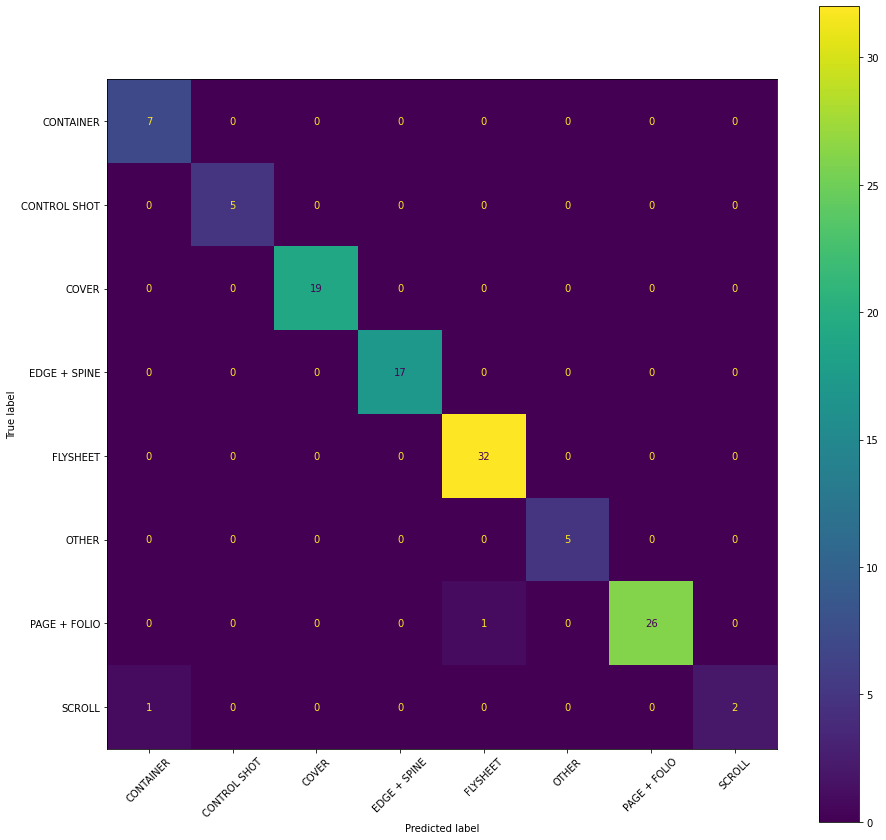

In [ ]:
plot_confusion_matrix(outputs,trainer=trainer)

In [ ]:
from flyswot_gym.core import create_test_results_df

In [ ]:
report_df = create_test_results_df(outputs,trainer, important_label='FLYSHEET', print_results=True,return_df=True)

misclasified:

y_true     y_pred    y_prob
10  PAGE + FOLIO   FLYSHEET  0.891519
61        SCROLL  CONTAINER  0.625756

Number of wrong predictions of FLYSHEET label: 1

Percentage of wrong predictions of FLYSHEET label: 0.8695652173913043

In [ ]:
mistakes_df = report_df[report_df.y_true != report_df.y_pred]

In [ ]:
mistakes_df['y_prob'].max()

0.89151853

In [ ]:
from flyswot_gym.core import create_mistakes_image_navigator

Column
    [0] DiscreteSlider(formatter='%d', options=[0, 1], value=0)
    [1] ParamFunction(function)
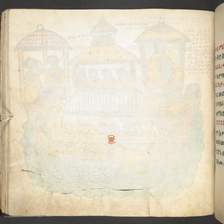

In [ ]:
create_mistakes_image_navigator(report_df, flyswot_data, trainer)

## Push model to the hub? 

Once we have explored some of the model behaviour above we *should* have a better sense of whether it's a good model for our particular use case. In particular, we may explore how the model performs on one particular label.

In [ ]:
trainer.push_to_hub("finshed training")

## TODOs
- generate a model card automagically based on some of the metric results already included 

